In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading raw data
df = pd.read_csv("/Users/hayden_hynes/Desktop/References/Personal Projects/operational-systems-performance/data/raw/Location1.csv")

# Previewing the data
df.head()


,Time,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power
0,2017-01-02 00:00:00,28.5,85,24.5,1.44,1.26,146,162,1.4,0.1635
1,2017-01-02 01:00:00,28.4,86,24.7,2.06,3.99,151,158,4.4,0.1424
2,2017-01-02 02:00:00,26.8,91,24.5,1.30,2.78,148,150,3.2,0.1214
3,2017-01-02 03:00:00,27.4,88,24.3,1.30,2.69,58,105,1.6,0.1003
4,2017-01-02 04:00:00,27.3,88,24.1,2.47,4.43,58,84,4.0,0.0793


In [ ]:
# Converting time column to datetime
df['Time'] = pd.to_datetime(df['Time'])

# Sorting by time just to be safe
df = df.sort_values('Time')

# Creating time based features
df['date'] = df['Time'].dt.date
df['hour'] = df['Time'].dt.hour
df['day_of_week'] = df['Time'].dt.dayofweek # 0 = Monday, 6 = Sunday
df['month'] = df['Time'].dt.month

df.head()

,Time,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power,date,hour,day_of_week,month
0,2017-01-02 00:00:00,28.5,85,24.5,1.44,1.26,146,162,1.4,0.1635,2017-01-02,0,0,1
1,2017-01-02 01:00:00,28.4,86,24.7,2.06,3.99,151,158,4.4,0.1424,2017-01-02,1,0,1
2,2017-01-02 02:00:00,26.8,91,24.5,1.30,2.78,148,150,3.2,0.1214,2017-01-02,2,0,1
3,2017-01-02 03:00:00,27.4,88,24.3,1.30,2.69,58,105,1.6,0.1003,2017-01-02,3,0,1
4,2017-01-02 04:00:00,27.3,88,24.1,2.47,4.43,58,84,4.0,0.0793,2017-01-02,4,0,1


In [6]:
# Selecting operationally relevent columns
operational_df = df[[
  'Time',
  'windspeed_100m',
  'Power',
  'date',
  'hour',
  'day_of_week',
  'month'
]].copy()

# Renaming columns for clarity purposes
operational_df = operational_df.rename(columns={
  'windspeed_100m': 'wind_speed_100m',
  'Power': 'power_output'
})

operational_df.head()

,Time,wind_speed_100m,power_output,date,hour,day_of_week,month
0,2017-01-02 00:00:00,1.26,0.1635,2017-01-02,0,0,1
1,2017-01-02 01:00:00,3.99,0.1424,2017-01-02,1,0,1
2,2017-01-02 02:00:00,2.78,0.1214,2017-01-02,2,0,1
3,2017-01-02 03:00:00,2.69,0.1003,2017-01-02,3,0,1
4,2017-01-02 04:00:00,4.43,0.0793,2017-01-02,4,0,1


In [ ]:
# Getting the basic descriptive statistics
operational_df[['wind_speed_100m', 'power_output']].describe()

,wind_speed_100m,power_output
count,43800.000000,43800.000000
mean,6.284431,0.405385
std,2.685216,0.288322
min,0.100000,0.000000
25%,4.380000,0.148900
50%,6.080000,0.347650
75%,7.990000,0.659600
max,20.650000,0.991300


In [8]:
# The daily average power output
daily_power = (
  operational_df.groupby('date')['power_output'].mean().reset_index()
)

daily_power.head()

,date,power_output
0,2017-01-02,0.194150
1,2017-01-03,0.230358
2,2017-01-04,0.868033
3,2017-01-05,0.698042
4,2017-01-06,0.322771


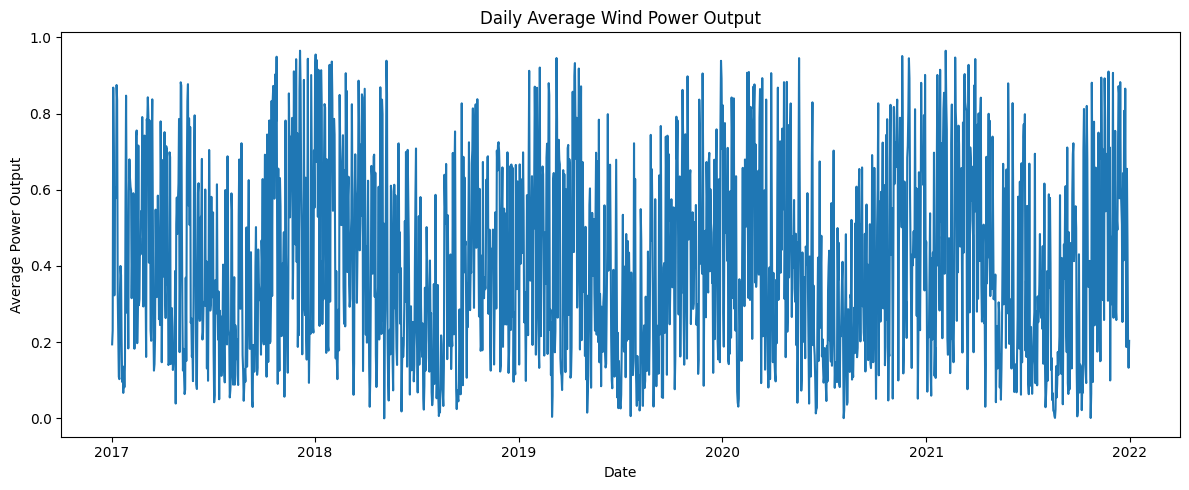

In [9]:
# Plotting the daily average power output
plt.figure(figsize=(12, 5))
plt.plot(daily_power['date'], daily_power['power_output'])
plt.title('Daily Average Wind Power Output')
plt.xlabel('Date')
plt.ylabel('Average Power Output')
plt.tight_layout()
plt.show()

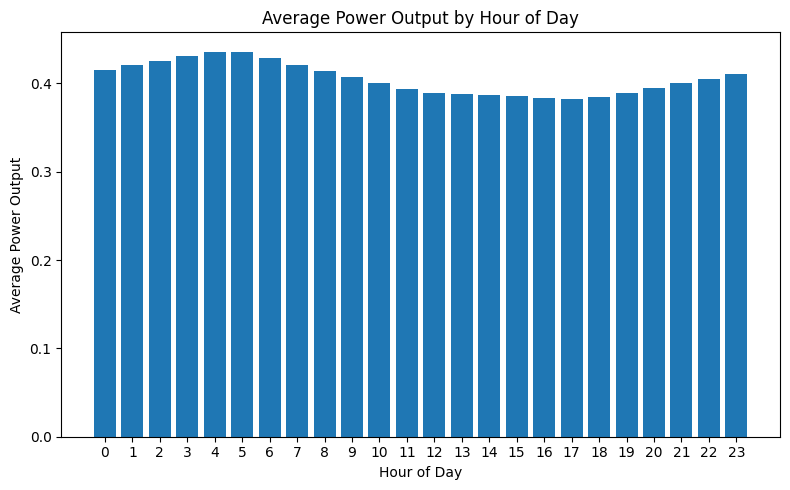

In [10]:
# This is the average power output by hour of day
hourly_power = (
  operational_df.groupby('hour')['power_output'].mean().reset_index()
)

plt.figure(figsize=(8, 5))
plt.bar(hourly_power['hour'], hourly_power['power_output'])
plt.title('Average Power Output by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Power Output')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

In [12]:
# Calculating the mean and standard deviation of the daily power output
mean_power = daily_power['power_output'].mean()
std_power = daily_power['power_output'].std()

upper_threshold = mean_power + 2 * std_power
lower_threshold = mean_power - 2 * std_power

mean_power, upper_threshold, lower_threshold

(np.float64(0.40538510502283104),
 np.float64(0.8960255275451589),
 np.float64(-0.08525531749949677))

In [13]:
# Flagging anomalies
daily_power['anomaly'] = (
  (daily_power['power_output'] > upper_threshold) |
  (daily_power['power_output'] < lower_threshold)
)

# Counting anomalies
daily_power['anomaly'].value_counts()

anomaly
False    1783
True       42
Name: count, dtype: int64

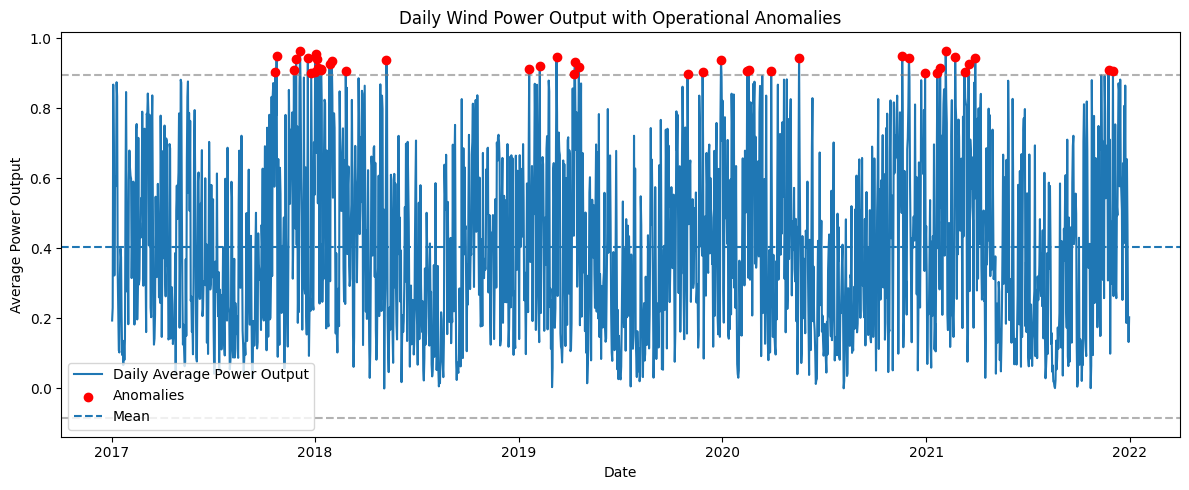

In [18]:
plt.figure(figsize=(12, 5))

# Plotting the normal daily power
plt.plot(
  daily_power['date'],
  daily_power['power_output'],
  label='Daily Average Power Output'
)

# Highlighting anomalies
anomalies = daily_power[daily_power['anomaly']]

plt.scatter(
  anomalies['date'],
  anomalies['power_output'],
  color='red',
  label='Anomalies',
  zorder=5
)

plt.axhline(mean_power, linestyle='--', label='Mean')
plt.axhline(upper_threshold, linestyle='--', color='grey', alpha=0.6)
plt.axhline(lower_threshold, linestyle='--', color='grey', alpha=0.6)

plt.title('Daily Wind Power Output with Operational Anomalies')
plt.xlabel('Date')
plt.ylabel('Average Power Output')
plt.legend()
plt.tight_layout()
plt.show()

What my analysis objectively shows:

- Daily average power output:
  - Mean is roughly 0.41 of maximum capacity
  - Natural variability is high, which is expected for wind generation

- Anomalies
  - 42 anomaly days out of roughly 1,825 days
  - Roughly 2.3% of days
  - All anomalies are high-output events, not system failures

- Hourly pattern
  - Output is higher in early morning and late evening
  - The midday lull is visible but not extreme